### Import Packages

In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import torch
from transformers import ViTImageProcessor, ViTForImageClassification, ViTFeatureExtractor, ViTConfig, TrainingArguments, Trainer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.nn import BCEWithLogitsLoss
from datasets import Dataset

/Users/kyleandrecastro/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kyleandrecastro/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Image and Labels Loading and Matching

In [2]:
# Load the Data from CSV
csv_file = "clean_MovieGenre.csv"  # Path to your CSV file
df = pd.read_csv(csv_file)

# Specify the binarized columns
binarized_columns = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 
                     'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 
                     'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']

In [3]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, processor):
        self.images = images
        self.labels = labels.astype(np.float32) 

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Process image using the provided processor
        inputs = self.processor(images=image, return_tensors="pt")
        processed_image = inputs.pixel_values.squeeze(0)  # Remove batch dimension

        return {"pixel_values": processed_image, "labels": label}


In [4]:
image_folder = "downloaded_images" #sample_images for developing, downloaded_images for final
images = []
labels = []
batch_size = 128  

# Load images and labels in batches
num_batches = len(df) // batch_size + 1

for batch_num in tqdm(range(num_batches)):
    start_idx = batch_num * batch_size
    end_idx = min((batch_num + 1) * batch_size, len(df))
    
    batch_df = df.iloc[start_idx:end_idx]
    batch_images = []
    batch_labels = []
    
    for index, row in batch_df.iterrows():
        filename = str(row.iloc[0]) + ".jpg"  # filenames match the imdbIDs
        label = [int(row[column]) for column in binarized_columns]  # Extract binarized labels for each genre

        image_path = os.path.join(image_folder, filename)
        try:
            image = Image.open(image_path)  # Open image using PIL
            image = image.convert("RGB")  # Convert image to RGB mode if necessary
            image_array = np.array(image)  # Convert PIL Image to numpy array
            batch_images.append(image_array)
            batch_labels.append(label)
        except Exception as e:
            pass
    # Concatenate the batches of images and labels
    if batch_images:
        images.append(np.array(batch_images))
        labels.append(np.array(batch_labels))

# Concatenate all batches into single numpy arrays
if images:
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)

  0%|          | 0/260 [00:00<?, ?it/s]

100%|██████████| 260/260 [00:19<00:00, 13.30it/s]


### Sample Posters

Images shape: (33275, 268, 182, 3)
Labels shape: (33275, 23)


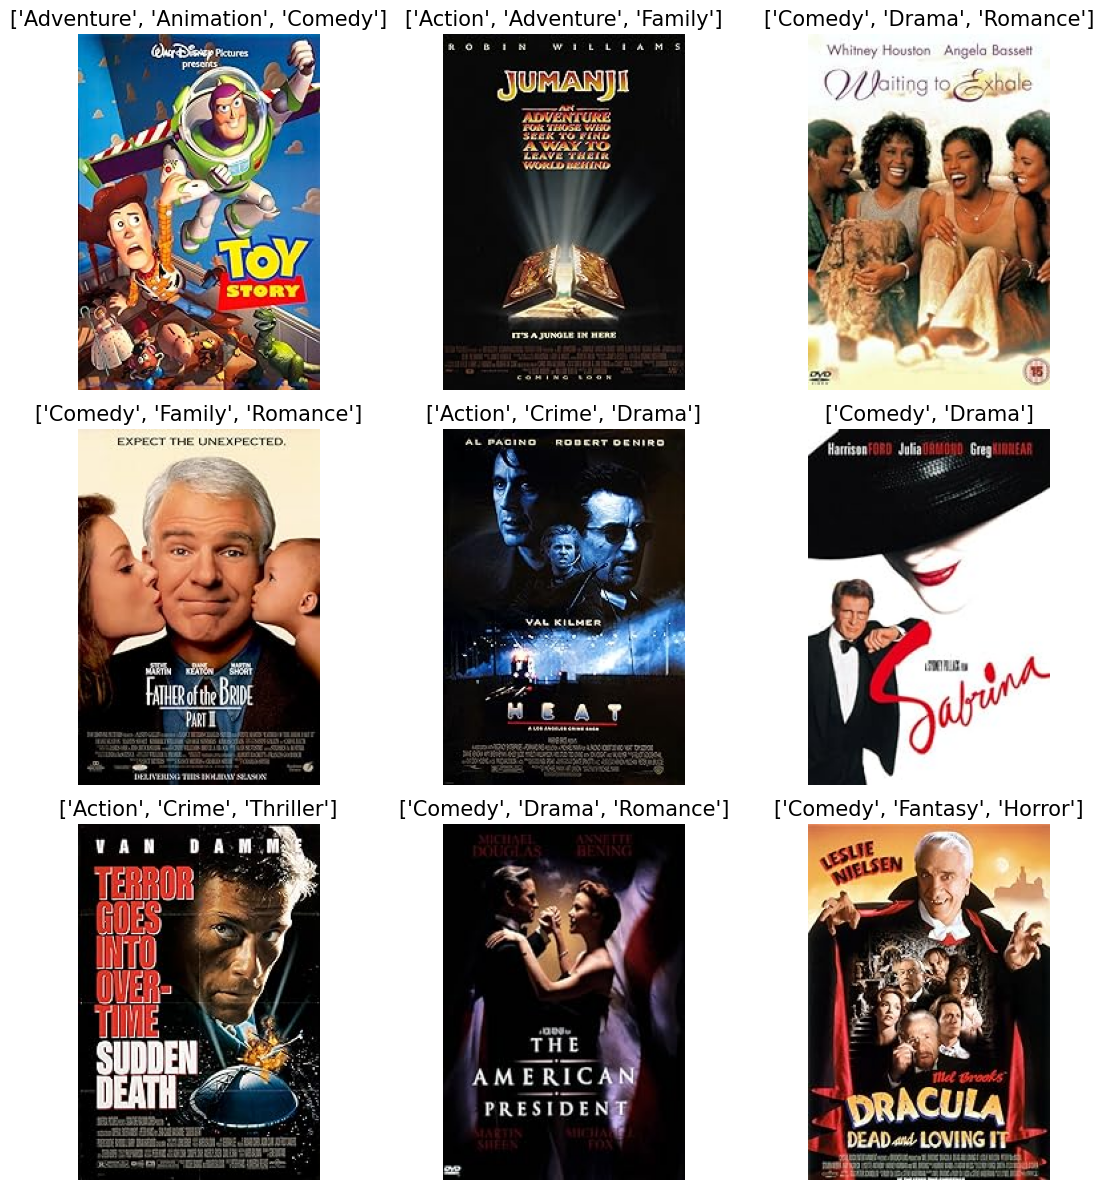

In [5]:
# Print the shapes of the loaded data
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

# Display sample images
plt.figure(figsize=(12, 12))
for i in range(9):
	ax = plt.subplot(3, 3, i + 1)
	plt.imshow(images[i])
	plt.axis('off')
	plt.title([column for column, label in zip(binarized_columns, labels[i]) if label == 1], fontsize=15)
plt.tight_layout()
plt.show()

### Preprocessing

In [6]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Print the shapes of the split datasets
print("Training images shape:", X_train.shape)
print("Training labels shape:", y_train.shape)

print("Validation images shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)

print("Testing images shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

Training images shape: (26620, 268, 182, 3)
Training labels shape: (26620, 23)
Validation images shape: (3328, 268, 182, 3)
Validation labels shape: (3328, 23)
Testing images shape: (3327, 268, 182, 3)
Testing labels shape: (3327, 23)


In [7]:
#Display Distribution
train_label_distribution = np.sum(y_train, axis=0)
val_label_distribution = np.sum(y_val, axis=0)
test_label_distribution = np.sum(y_test, axis=0)

combined_data = {
    "Label": binarized_columns,
    "Train Distribution": train_label_distribution,
    "Validation Distribution": val_label_distribution,
    "Test Distribution": test_label_distribution
}

df = pd.DataFrame(combined_data)
print(df)

          Label  Train Distribution  Validation Distribution  \
0        Action                3608                      431   
1     Adventure                2567                      308   
2     Animation                1189                      125   
3     Biography                1325                      192   
4        Comedy                8517                     1071   
5         Crime                3496                      407   
6   Documentary                2629                      361   
7         Drama               13432                     1641   
8        Family                1417                      166   
9       Fantasy                1365                      168   
10    Film-Noir                 211                       31   
11      History                 971                      136   
12       Horror                2646                      340   
13        Music                 858                       99   
14      Musical                 543     

In [12]:
# Ensure pixel values are in the range of 0 to 255 and are float32
X_train = np.clip(X_train, 0, 255).astype(np.float32)
X_val = np.clip(X_val, 0, 255).astype(np.float32)
X_test = np.clip(X_test, 0, 255).astype(np.float32)

X_train = np.transpose(X_train, (0, 3, 1, 2))
X_val = np.transpose(X_val, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

# Ensure labels are int64
y_train = y_train.astype(np.int64)
y_val = y_val.astype(np.int64)
y_test = y_test.astype(np.int64)

: 

In [ ]:
# Convert to HuggingFace Datasets
train_dataset = Dataset.from_dict({'pixel_values': X_train, 'labels': y_train})
val_dataset = Dataset.from_dict({'pixel_values': X_val, 'labels': y_val})
test_dataset = Dataset.from_dict({'pixel_values': X_test, 'labels': y_test})

ArrowInvalid: Integer value 2147483732 not in range: -2147483648 to 2147483647

### Modeling

In [ ]:
# Load the default ViT model configuration
vit_config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')

# Update the image size in the configuration
vit_config = ViTConfig(
    image_size=(268, 182),
    problem_type="multi_label_classification",
	num_labels=len(binarized_columns),
    is_classifier=True,
    classifier_activation="sigmoid"
)

/Users/kyleandrecastro/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# Model Specification
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', config=vit_config, ignore_mismatched_sizes=True)

#utilize cuda if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
model = model.to(device)

# Utilize MPS backend if available (specific to Apple Silicon)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print("Using device:", device)
model = model.to(device)

/Users/kyleandrecastro/Library/Python/3.9/lib/python/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized because the shapes did not match:
- embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 177, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use i

Using device: cpu
Using device: mps


### Training

In [ ]:
training_args = TrainingArguments(
    output_dir='output',
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8,   
    num_train_epochs=3,             
    logging_dir='./logs',
    logging_steps=50,               
    save_steps=200,                 
    evaluation_strategy="epoch",    
    fp16=True,                      
    gradient_accumulation_steps=2,  
    dataloader_num_workers=2,       
    learning_rate=2e-5,            
    weight_decay=0.01,             
    save_total_limit=2,            
)

In [ ]:
def compute_metrics(pred):
    logits = pred.predictions
    labels = pred.label_ids
    
    # Apply sigmoid to get probabilities
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()
    
    # Define a threshold to get binary predictions
    threshold = 0.5
    predictions = (probabilities > threshold).astype(int)
    
    f1 = f1_score(labels, predictions, average='micro')
    # accuracy = accuracy_score(labels, predictions)
    
    return {
        'f1_score': f1,
        # 'accuracy': accuracy,
    }

In [ ]:
# Custom Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").float()  # Ensure labels are float
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = BCEWithLogitsLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

 13%|█▎        | 100/745 [03:18<19:45,  1.84s/it]

{'loss': 0.4547, 'grad_norm': 0.2631235122680664, 'learning_rate': 4.328859060402685e-05, 'epoch': 0.67}


                                                 
 20%|██        | 149/745 [05:53<35:29,  3.57s/it]

{'eval_loss': 0.33063241839408875, 'eval_f1_score': 0.3665987780040733, 'eval_runtime': 26.3095, 'eval_samples_per_second': 11.327, 'eval_steps_per_second': 0.722, 'epoch': 1.0}


 27%|██▋       | 200/745 [07:54<20:40,  2.28s/it]  

{'loss': 0.3313, 'grad_norm': 0.17580527067184448, 'learning_rate': 3.6577181208053695e-05, 'epoch': 1.34}


                                                 
 40%|████      | 298/745 [11:21<11:02,  1.48s/it]

{'eval_loss': 0.28173691034317017, 'eval_f1_score': 0.3665987780040733, 'eval_runtime': 17.9425, 'eval_samples_per_second': 16.609, 'eval_steps_per_second': 1.059, 'epoch': 2.0}


 40%|████      | 300/745 [11:25<41:07,  5.55s/it]

{'loss': 0.2881, 'grad_norm': 0.1305871158838272, 'learning_rate': 2.986577181208054e-05, 'epoch': 2.01}


 54%|█████▎    | 400/745 [14:24<10:16,  1.79s/it]

{'loss': 0.271, 'grad_norm': 0.10089771449565887, 'learning_rate': 2.3154362416107384e-05, 'epoch': 2.68}


                                                 
 60%|██████    | 447/745 [16:05<07:18,  1.47s/it]

{'eval_loss': 0.26833295822143555, 'eval_f1_score': 0.3665987780040733, 'eval_runtime': 17.744, 'eval_samples_per_second': 16.794, 'eval_steps_per_second': 1.071, 'epoch': 3.0}


 67%|██████▋   | 500/745 [17:39<07:08,  1.75s/it]

{'loss': 0.2674, 'grad_norm': 0.10369590669870377, 'learning_rate': 1.644295302013423e-05, 'epoch': 3.36}


                                                     
 80%|████████  | 596/745 [34:23<04:09,  1.68s/it]

{'eval_loss': 0.2637656033039093, 'eval_f1_score': 0.3665987780040733, 'eval_runtime': 19.678, 'eval_samples_per_second': 15.144, 'eval_steps_per_second': 0.966, 'epoch': 4.0}


 81%|████████  | 600/745 [34:34<10:45,  4.45s/it]

{'loss': 0.2604, 'grad_norm': 0.17401990294456482, 'learning_rate': 9.731543624161075e-06, 'epoch': 4.03}


 94%|█████████▍| 700/745 [37:39<01:23,  1.86s/it]

{'loss': 0.2601, 'grad_norm': 0.11318140476942062, 'learning_rate': 3.02013422818792e-06, 'epoch': 4.7}


                                                 
100%|██████████| 745/745 [39:22<00:00,  3.17s/it]

{'eval_loss': 0.26228994131088257, 'eval_f1_score': 0.3665987780040733, 'eval_runtime': 20.6297, 'eval_samples_per_second': 14.445, 'eval_steps_per_second': 0.921, 'epoch': 5.0}
{'train_runtime': 2362.6038, 'train_samples_per_second': 5.037, 'train_steps_per_second': 0.315, 'train_loss': 0.3017900172496002, 'epoch': 5.0}


TrainOutput(global_step=745, training_loss=0.3017900172496002, metrics={'train_runtime': 2362.6038, 'train_samples_per_second': 5.037, 'train_steps_per_second': 0.315, 'total_flos': 8.964331575662735e+17, 'train_loss': 0.3017900172496002, 'epoch': 5.0})

### Testing

In [ ]:
# Ensure processor has the correct image size
processor.size = (268, 182)  # Set the processor size to match the model

# Perform inference
model.eval()
predicted_probabilities = []

for i in range(0, len(X_test), batch_size):
    # Process batch inputs
    batch_images = X_test[i:i+batch_size]
    
    # Convert numpy arrays to lists of PIL images and process
    batch_inputs = processor(images=[Image.fromarray(img.transpose(1, 2, 0)) for img in batch_images], return_tensors="pt") 
    batch_inputs = {k: v.to(device) for k, v in batch_inputs.items()}
    
    with torch.no_grad():
        # Forward pass
        outputs = model(**batch_inputs)
    
    # Get the predicted logits
    logits = outputs.logits
    
    # Convert logits to probabilities using sigmoid
    probabilities = torch.sigmoid(logits)
    
    # Append predicted probabilities for this batch
    predicted_probabilities.append(probabilities.cpu().numpy())

# Concatenate predicted probabilities for all batches
predicted_probabilities = np.concatenate(predicted_probabilities, axis=0)


In [ ]:
# Convert lists to NumPy arrays
y_test_np = np.array(y_test)
predicted_probabilities_np = np.array(predicted_probabilities)

# Ensure that the arrays have the appropriate shape
y_test_np = np.vstack([np.array(y) for y in y_test_np])

# Define the threshold for binary classification
threshold = 0.5

# Threshold predicted probabilities to obtain binary predictions
predicted_labels_np = (predicted_probabilities_np > threshold).astype(int)

### Evaluation

In [ ]:
# Initialize lists to store F1 scores and accuracies for each label
f1_scores = []
accuracies = []
predicted_binary_labels = (predicted_probabilities > threshold).astype(int)

# Iterate over each label
for i, label in enumerate(binarized_columns):
    # Calculate F1 score
    f1 = f1_score(y_test_np[:, i], predicted_labels_np[:, i], average='binary')
    f1_scores.append(f1)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test[:, i], predicted_binary_labels[:, i])
    accuracies.append(accuracy)

data = {
    "Label": binarized_columns,
    "F1 Score": f1_scores,
    "Accuracy": accuracies
}

df = pd.DataFrame(data)
print(df)

# Compute average F1 score
avg_f1_score = np.mean(f1_scores)
print("\nAverage F1 score:", avg_f1_score)

# Compute average accuracy
average_accuracy = sum(accuracies) / len(accuracies)
print("Average accuracy:", average_accuracy)

          Label  F1 Score  Accuracy
0        Action  0.000000  0.922559
1     Adventure  0.000000  0.885522
2     Animation  0.000000  0.986532
3     Biography  0.000000  0.956229
4        Comedy  0.000000  0.676768
5         Crime  0.000000  0.835017
6   Documentary  0.000000  0.983165
7         Drama  0.730769  0.575758
8        Family  0.000000  0.976431
9       Fantasy  0.000000  0.973064
10    Film-Noir  0.000000  0.929293
11      History  0.000000  0.949495
12       Horror  0.000000  0.949495
13        Music  0.000000  0.973064
14      Musical  0.000000  0.892256
15      Mystery  0.000000  0.932660
16      Romance  0.000000  0.734007
17       Sci-Fi  0.000000  0.979798
18        Short  0.000000  0.973064
19        Sport  0.000000  0.979798
20     Thriller  0.000000  0.942761
21          War  0.000000  0.922559
22      Western  0.000000  0.946128

Average F1 score: 0.03177257525083612
Average accuracy: 0.9076269945835161


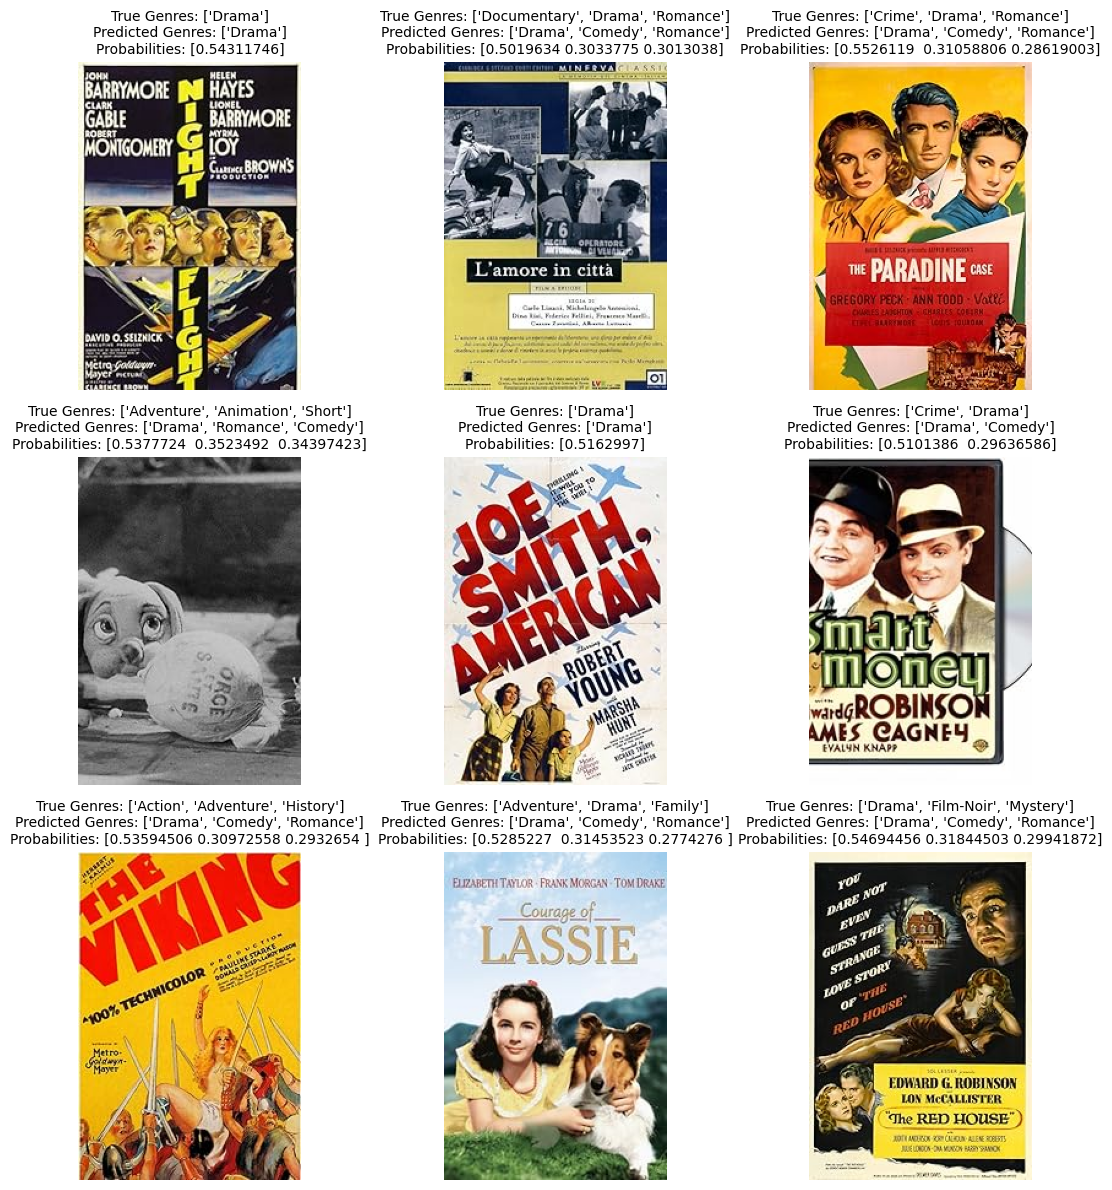

In [ ]:
def display(X_test, y_test, predicted_probabilities, binarized_columns, threshold=0.5):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for idx, ax in enumerate(axes.flat):
        if idx < len(X_test):
            poster = X_test[idx].transpose(1, 2, 0)  # Transpose back to (height, width, channels)
            true_labels = [binarized_columns[i] for i, label in enumerate(y_test[idx]) if label == 1]
            predicted_genre_probabilities = predicted_probabilities[idx]

            # Sort predicted probabilities and select labels based on the number of true labels
            num_true_labels = len(true_labels)
            top_predicted_idx = np.argsort(predicted_genre_probabilities)[::-1][:num_true_labels]
            predicted_genre_labels = [binarized_columns[i] for i in top_predicted_idx]
            top_predicted_probabilities = predicted_genre_probabilities[top_predicted_idx]

            ax.imshow(poster)
            ax.set_title(f"True Genres: {true_labels}\nPredicted Genres: {predicted_genre_labels}\nProbabilities: {top_predicted_probabilities}", fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')  # Hide empty subplots
        
    plt.tight_layout()
    plt.show()

display(X_test, y_test, predicted_probabilities, binarized_columns)
